In [1]:
from collections import OrderedDict, namedtuple
import time

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import theano as th
import theano.tensor as T

%load_ext autoreload
%autoreload 2

In [47]:
from utils.cartpole import CartPole
from utils import VariableStore, Linear, SGD, momentum

In [48]:
seed = int(time.time())
print seed
rng = T.shared_randomstreams.RandomStreams(seed)

1445883786


In [53]:
STATE_DIM = 4
ACTION_DIM = 1
EXPLORE_RANGE = 0.5

## Variables

X = T.matrix("X")
vs_actor = VariableStore("vs_a")
vs_critic = VariableStore("vs_q")

# Optionally directly provide actions predicted
actions = T.matrix("actions")
# Q target values
q_targets = T.vector("q_targets")
# Learning rate
lr = T.scalar("lr")


## Computations

# Deterministic policy: linear map
a_pred = Linear(X, STATE_DIM, ACTION_DIM, vs_actor)

# Exploration policy: add noise
a_explore = a_pred + rng.uniform(a_pred.shape, -EXPLORE_RANGE, EXPLORE_RANGE, ndim=2)

# Critic: again a linear map
Critic = namedtuple("Critic", ["pred", "targets", "cost", "updates"])
def make_critic(actions, targets, vs, lr=0.01):
    q_pred = Linear(T.concatenate([X, actions], axis=1),
                    STATE_DIM + ACTION_DIM, 1, vs, "q")
    q_pred = q_pred.reshape((-1,))
    q_cost = ((q_targets - q_pred) ** 2).mean()
    q_updates = momentum(q_cost, vs.vars.values(), lr)
    return Critic(q_pred, targets, q_cost, q_updates)

# Critic 1: actions given
critic_given = make_critic(actions, q_targets, vs_critic, lr)
# Critic 2: with deterministic policy
critic_det = make_critic(a_pred, q_targets, vs_critic, lr)
# Critic 3: with noised / exploration policy
critic_exp = make_critic(a_explore, q_targets, vs_critic, lr)

# Actor-critic learning w/ critic 3
# NB, need to flatten all timesteps into a single batch
updates = OrderedDict(critic_exp.updates)
updates.update(momentum(-critic_exp.pred.mean(), vs_actor.vars.values(), lr)) # policy gradient


## Functions

# On-policy action prediction function
f_action_on = th.function([X], a_pred)
# Off-policy action prediction function
f_action_off = th.function([X], a_explore)

# Q-function
f_q = th.function([X, actions], critic_given.pred)

# Actor-critic update
f_update = th.function([X, q_targets, lr], (critic_exp.cost, critic_exp.pred),
                       updates=updates)

In [54]:
def run_episode(f_onpolicy, f_offpolicy, f_q):
    """
    Simulate a trajectory and record states and rewards.
    Return a batch of (s, a, r, y), where `y` is a TD-learning error backup.
    """
    cp = CartPole()
    trace = cp.single_episode(policy=lambda *args: f_offpolicy(np.array(args).reshape((1, -1))))
    
    # states: list of s_t
    # actions: list of a_t = u(s_t)
    # rewards: list of r_t
    states, actions, rewards = [], [], []
    for state_t, action_t, reward_t, _, _ in trace:
        states.append(state_t)
        #print "action_t", action_t
        actions.append(0 if action_t < 0 else 1)
        rewards.append(reward_t)

    states, actions, rewards = np.array(states), np.array(actions).astype(np.int32), np.array(rewards)
    #rewards = rewards * 2 + 1
    
    return len(trace), states, actions, rewards

In [55]:
# Keep a replay buffer of states, actions, rewards, targets
R_states = np.empty((0, STATE_DIM), dtype=th.config.floatX)
R_actions = np.empty((0,), dtype=np.int32)
R_rewards = np.empty((0,), dtype=np.int32)

steps = []
q_costs = []

BATCH_SIZE = 50
LR = 0.01
GAMMA = 0.99

for t in xrange(500):
    steps_t, states_t, actions_t, rewards_t = run_episode(f_action_on, f_action_off, f_q)
    
    R_states = np.append(R_states, states_t, axis=0)
    R_actions = np.append(R_actions, actions_t)
    R_rewards = np.append(R_rewards, rewards_t)
    
    # Sample a training batch.
    if len(R_states) < BATCH_SIZE:
        # Not enough data. Keep collecting trajectories.
        continue
    idxs = np.random.choice(len(R_states) - 1, size=BATCH_SIZE, replace=False)
    b_states, b_actions, b_rewards = R_states[idxs], R_actions[idxs], R_rewards[idxs]
    
    # Compute targets (TD error backups) given current Q function.
    next_states = R_states[idxs + 1] # may bork at the end of each trajectory, but I don't care
    next_actions = f_action_on(next_states)
    b_targets = b_rewards + GAMMA * f_q(next_states, next_actions).reshape((-1,))
    
    # SGD update.
    cost_t, _ = f_update(b_states, b_targets, LR)
    
    steps.append(steps_t)
    q_costs.append(cost_t)
    print "%i\t% 4i\t%10f" % (t, steps_t, cost_t)

2	  17	  0.037254
3	  13	  0.051069
4	  11	  0.051216
5	  17	  0.050576
6	  57	  0.016079
7	  52	  0.000826
8	  16	  0.059994
9	  25	  0.053256
10	  16	  0.027622
11	  51	  0.027293
12	  17	  0.035877
13	  22	  0.062628
14	  16	  0.049685
15	  25	  0.026444
16	  16	  0.076746
17	  12	  0.042507
18	  33	  0.020623
19	  28	  0.048086
20	  22	  0.017242
21	  26	  0.024842
22	  25	  0.010256
23	  20	  0.039299
24	  21	  0.025559
25	  18	  0.003774
26	  13	  0.061228
27	  12	  0.004261
28	  26	  0.014886
29	  18	  0.013588
30	  17	  0.007062
31	  19	  0.024110
32	  15	  0.013681
33	  19	  0.023760
34	  20	  0.014410
35	  26	  0.010932
36	  13	  0.038423
37	  16	  0.084793
38	  15	  0.033714
39	  15	  0.046788
40	  12	  0.044162
41	  14	  0.061299
42	  12	  0.081888
43	  27	  0.031570
44	  12	  0.012625
45	  27	  0.055817
46	  28	  0.068430
47	  11	  0.015993
48	  34	  0.066997
49	  31	  0.018840
50	  26	  0.016756
51	  38	  0.093386
52	  24	  0.011518
53	  35	  0.009493
54	  11	  0.009326
5

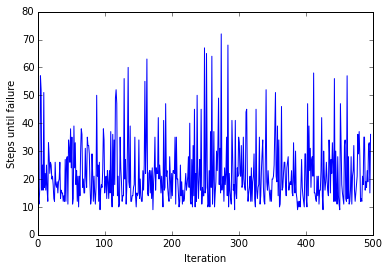

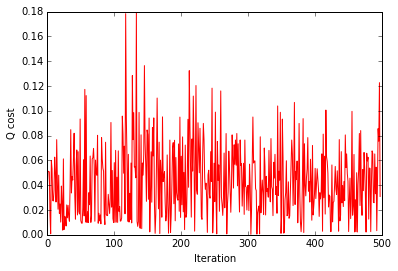

In [56]:
plt.figure(0)
plt.plot(steps)
plt.xlabel("Iteration")
plt.ylabel("Steps until failure")

plt.figure(1)
plt.plot(q_costs, "r")
plt.xlabel("Iteration")
plt.ylabel("Q cost")